In [38]:
import chipwhisperer as cw
import matplotlib.pyplot as plt

n = 4

try :
    scope.dis()
    target.dis()
except Exception as e:
    pass

scope = cw.scope()
target = cw.target(scope)

scope.default_setup()

cw.program_target(scope, cw.programmers.STM32FProgrammer, "./err0r-CWNANO-true.hex")

scope.arm()


scope.adc.samples = 1000


See https://chipwhisperer.readthedocs.io/en/latest/api.html#firmware-update


Detected known STMF32: STM32F04xxx
Extended erase (0x44), this can take ten seconds or more
Attempting to program 5171 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 5171 bytes


In [39]:
import time

scope.io.clkout = 7.5E6
def reboot_flush():            
    scope.io.nrst = False
    time.sleep(0.05)
    scope.io.nrst = "high_z"
    time.sleep(0.05)
    #Flush garbage too
    target.flush()

def reset_target(scope): 
    scope.io.nrst = 'low'
    time.sleep(0.05)
    scope.io.nrst = 'high'
    time.sleep(0.05)

def cap_pass_trace(pass_guess):
    ret = ""
    reset_target(scope)
    num_char = target.in_waiting()
    while num_char > 0:
        ret += target.read(num_char, 16)
        time.sleep(0.01)
        num_char = target.in_waiting()

    scope.arm()
#     target.write(pass_guess)
    target.simpleserial_write('h', pass_guess)

    ret = scope.capture()
    if ret:
        print('Timeout happened during acquisition')

    trace = scope.get_last_trace()
    return trace

In [40]:
msg = bytearray([1,2,3,4,5,6,7,8])

In [41]:
import chipwhisperer.common.results.glitch as glitch
gc = glitch.GlitchController(groups=["success", "reset", "normal"], parameters=["repeat", "ext_offset"])
gc.display_stats()

IntText(value=0, description='success count:', disabled=True)

IntText(value=0, description='reset count:', disabled=True)

IntText(value=0, description='normal count:', disabled=True)

FloatSlider(value=0.0, continuous_update=False, description='repeat setting:', disabled=True, max=10.0, readou…

FloatSlider(value=0.0, continuous_update=False, description='ext_offset setting:', disabled=True, max=10.0, re…

In [42]:
%matplotlib inline
import matplotlib.pylab as plt
fig = plt.figure()

<Figure size 432x288 with 0 Axes>

offset:100, repeat: 1, o/p:  [197, 136, 202, 63]
offset:101, repeat: 1, o/p:  [197, 136, 202, 63]
offset:102, repeat: 1, o/p:  [197, 136, 202, 63]
offset:103, repeat: 1, o/p:  [197, 136, 202, 63]
offset:104, repeat: 1, o/p:  [197, 136, 202, 63]
offset:106, repeat: 1, o/p:  [197, 136, 202, 63]
offset:108, repeat: 1, o/p:  [197, 136, 202, 63]
offset:111, repeat: 1, o/p:  [197, 136, 202, 63]
offset:112, repeat: 1, o/p:  [197, 136, 202, 63]
offset:113, repeat: 1, o/p:  [197, 136, 202, 63]
offset:114, repeat: 1, o/p:  [197, 136, 202, 63]
offset:115, repeat: 1, o/p:  [197, 136, 202, 63]
offset:116, repeat: 1, o/p:  [197, 136, 202, 63]
offset:117, repeat: 1, o/p:  [197, 136, 202, 63]
offset:118, repeat: 1, o/p:  [197, 136, 202, 63]
offset:119, repeat: 1, o/p:  [197, 136, 202, 63]
offset:126, repeat: 1, o/p:  [197, 136, 202, 63]
offset:128, repeat: 1, o/p:  [197, 136, 202, 63]
offset:129, repeat: 1, o/p:  [197, 136, 202, 63]
offset:130, repeat: 1, o/p:  [197, 136, 202, 63]
offset:131, repeat: 

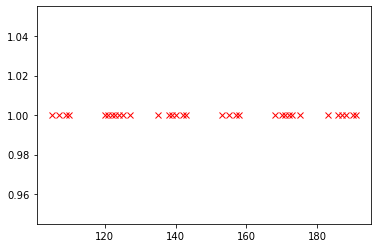

In [43]:
from importlib import reload
import chipwhisperer.common.results.glitch as glitch
from tqdm.notebook import trange
import struct

g_step = 1

gc.set_global_step(g_step)
gc.set_range("repeat", 1,1 )
gc.set_range("ext_offset", 100, 200) 
scope.glitch.repeat = 0

reboot_flush()
sample_size = 1
for glitch_setting in gc.glitch_values():
    scope.glitch.repeat = glitch_setting[0]
    scope.glitch.ext_offset = glitch_setting[1]
    successes = 0
    resets = 0
    for i in range(1):
        target.flush()
            
        scope.arm()
        
        #Do glitch loop
        target.simpleserial_write("h", msg)
        
        ret = scope.capture()
        
        val = target.simpleserial_read_witherrors('r', 4, glitch_timeout=10)#For loop check
        
        if ret:
            print('Timeout - no trigger')
            gc.add("reset", (scope.glitch.repeat, scope.glitch.ext_offset))
            plt.plot(scope.glitch.ext_offset, scope.glitch.repeat, 'xr', alpha=1)
            fig.canvas.draw()
            resets += 1

            #Device is slow to boot?
            reboot_flush()

        else:
            if val['valid'] is False:
                reboot_flush()
                gc.add("reset", (scope.glitch.repeat, scope.glitch.ext_offset))
                plt.plot(scope.glitch.ext_offset, scope.glitch.repeat, 'xr', alpha=1)
                fig.canvas.draw()
                resets += 1
            else:
                print(f'offset:{scope.glitch.ext_offset}, repeat: {scope.glitch.repeat}, o/p: ',[int(i) for i in val['payload']])
                gcnt = struct.unpack("<I", val['payload'])[0]
                
    if successes > 0:                
        print("successes = {}, resets = {}, repeat = {}, ext_offset = {}".format(successes, resets, scope.glitch.repeat, scope.glitch.ext_offset))
print("Done glitching")

In [44]:
lis = [87,73,78,33]
''.join([chr(i) for i in lis])

'WIN!'

In [45]:
target.dis()
scope.dis()

True